
Available States: ['Assam', 'Karnataka', 'Kerala', 'Meghalaya', 'West Bengal', 'Puducherry', 'Goa', 'Andhra Pradesh', 'Tamil Nadu', 'Odisha', 'Bihar', 'Gujarat', 'Madhya Pradesh', 'Maharashtra', 'Mizoram', 'Punjab', 'Uttar Pradesh', 'Haryana', 'Himachal Pradesh', 'Tripura', 'Nagaland', 'Chhattisgarh', 'Uttarakhand', 'Jharkhand', 'Delhi', 'Manipur', 'Jammu And Kashmir', 'Telangana', 'Arunachal Pradesh', 'Sikkim']
✅ Accuracy (state-wise): 0.9388

Classification Report:
                        precision    recall  f1-score   support

             Arecanut       1.00      0.75      0.86         4
            Arhar/Tur       0.80      1.00      0.89         4
               Banana       1.00      1.00      1.00         4
         Black pepper       1.00      1.00      1.00         2
          Castor seed       0.67      0.40      0.50         5
              Coconut       1.00      1.00      1.00         4
         Cotton(lint)       0.57      0.80      0.67         5
         Dry chillies

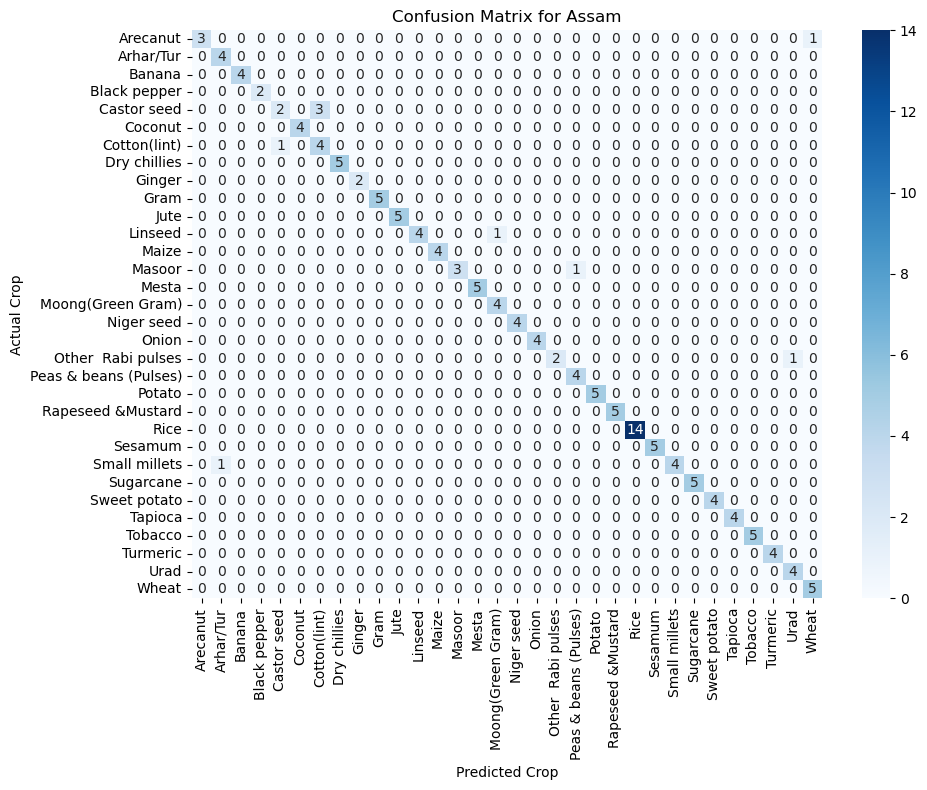


Available Seasons for this state: ['Whole Year', 'Kharif', 'Rabi', 'Autumn', 'Summer', 'Winter']

🌾 Suggested Crop for your state: Gram
Recommended area: 4.94 acres


In [51]:
# ---------------------------
# final_crop_predictor_statewise_highacc.py
# ---------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# -----------------------
# 1) LOAD DATA
# -----------------------
df = pd.read_csv("crop_yield.csv")
FEATURES = ['Season', 'State', 'Area', 'Annual_Rainfall', 'Fertilizer', 'Pesticide', 'Yield', 'Crop']
for c in FEATURES:
    if c not in df.columns:
        raise ValueError(f"Missing column {c}")

df = df[FEATURES].dropna().copy()
df['Season'] = df['Season'].astype(str).str.strip()
df['State']  = df['State'].astype(str).str.strip()
df['Crop']   = df['Crop'].astype(str).str.strip()

# -----------------------
# 2) STATE NORMALIZATION
# -----------------------
df['State'] = df['State'].str.lower()  # normalize
available_states = [s.title() for s in df['State'].unique()]
print("\nAvailable States:", available_states)

state_input = input("Enter State: ").strip().lower()
if state_input not in df['State'].unique():
    raise ValueError(f"State '{state_input}' not in dataset.")

df_state = df[df['State'] == state_input].copy()
if df_state.empty:
    raise ValueError("No data for this state!")

# -----------------------
# 2.1) REMOVE RARE CROPS
# -----------------------
crop_counts = df_state['Crop'].value_counts()
valid_crops = crop_counts[crop_counts > 1].index
df_state = df_state[df_state['Crop'].isin(valid_crops)]
if df_state.empty:
    raise ValueError("Not enough data after removing rare crops!")

# -----------------------
# 3) ENCODE & SCALE
# -----------------------
df_state['Season'] = df_state['Season'].str.lower()
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat = ohe.fit_transform(df_state[['Season']])
X_num = df_state[['Area','Annual_Rainfall','Fertilizer','Pesticide','Yield']].values

X = np.hstack([X_cat, X_num])
y = df_state['Crop'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------
# 4) TRAIN RANDOM FOREST (High Accuracy)
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(
    n_estimators=1500,       # More trees
    max_depth=None,          
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# -----------------------
# 5) EVALUATE
# -----------------------
y_pred = rf.predict(X_test)
print("✅ Accuracy (state-wise):", round(accuracy_score(y_test, y_pred),4))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title(f"Confusion Matrix for {state_input.title()}")
plt.xlabel("Predicted Crop")
plt.ylabel("Actual Crop")
plt.tight_layout()
plt.show()


# -----------------------
# 6) PREDICTION FUNCTION
# -----------------------
def predict_crop_statewise(season, area, rainfall, fert, pest, yield_val):
    season = season.strip().lower()
    if season not in df_state['Season'].unique():
        return f"Error: season '{season}' not in dataset."
    sample_cat = ohe.transform([[season]])
    sample_num = np.array([[area, rainfall, fert, pest, yield_val]])
    sample = np.hstack([sample_cat, sample_num])
    sample_scaled = scaler.transform(sample)
    return rf.predict(sample_scaled)[0]

# -----------------------
# 7) USER INPUT
# -----------------------
available_seasons = [s.title() for s in df_state['Season'].unique()]
print("\nAvailable Seasons for this state:", available_seasons)

season_input = input("Enter Season: ").strip()
area_input   = float(input("Enter Area of land (hectares): "))
rain_input   = float(input("Enter Annual Rainfall (mm): "))
fert_input   = float(input("Enter Fertilizer used (kg/ha): "))
pest_input   = float(input("Enter Pesticide used (kg/ha): "))
yield_input  = float(input("Enter Expected Yield: "))

best_crop = predict_crop_statewise(
    season_input, area_input, rain_input, fert_input, pest_input, yield_input
)

# Hectares → Acres
area_acres = area_input * 2.47105
print(f"\n🌾 Suggested Crop for your state: {best_crop}")
print(f"Recommended area: {area_acres:.2f} acres")                                                  

In [2]:
import pandas as pd
df = pd.read_csv("crop_yield.csv")

In [3]:
df.isna()

,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
19684,False,False,False,False,False,False,False,False,False,False
19685,False,False,False,False,False,False,False,False,False,False
19686,False,False,False,False,False,False,False,False,False,False
19687,False,False,False,False,False,False,False,False,False,False


In [4]:
df.isna().sum()

Crop               0
Crop_Year          0
Season             0
State              0
Area               0
Production         0
Annual_Rainfall    0
Fertilizer         0
Pesticide          0
Yield              0
dtype: int64

In [5]:
df.describe()

,Crop_Year,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
count,19689.000000,1.968900e+04,1.968900e+04,19689.000000,1.968900e+04,1.968900e+04,19689.000000
mean,2009.127584,1.799266e+05,1.643594e+07,1437.755177,2.410331e+07,4.884835e+04,79.954009
std,6.498099,7.328287e+05,2.630568e+08,816.909589,9.494600e+07,2.132874e+05,878.306193
min,1997.000000,5.000000e-01,0.000000e+00,301.300000,5.417000e+01,9.000000e-02,0.000000
25%,2004.000000,1.390000e+03,1.393000e+03,940.700000,1.880146e+05,3.567000e+02,0.600000
50%,2010.000000,9.317000e+03,1.380400e+04,1247.600000,1.234957e+06,2.421900e+03,1.030000
75%,2015.000000,7.511200e+04,1.227180e+05,1643.700000,1.000385e+07,2.004170e+04,2.388889
max,2020.000000,5.080810e+07,6.326000e+09,6552.700000,4.835407e+09,1.575051e+07,21105.000000


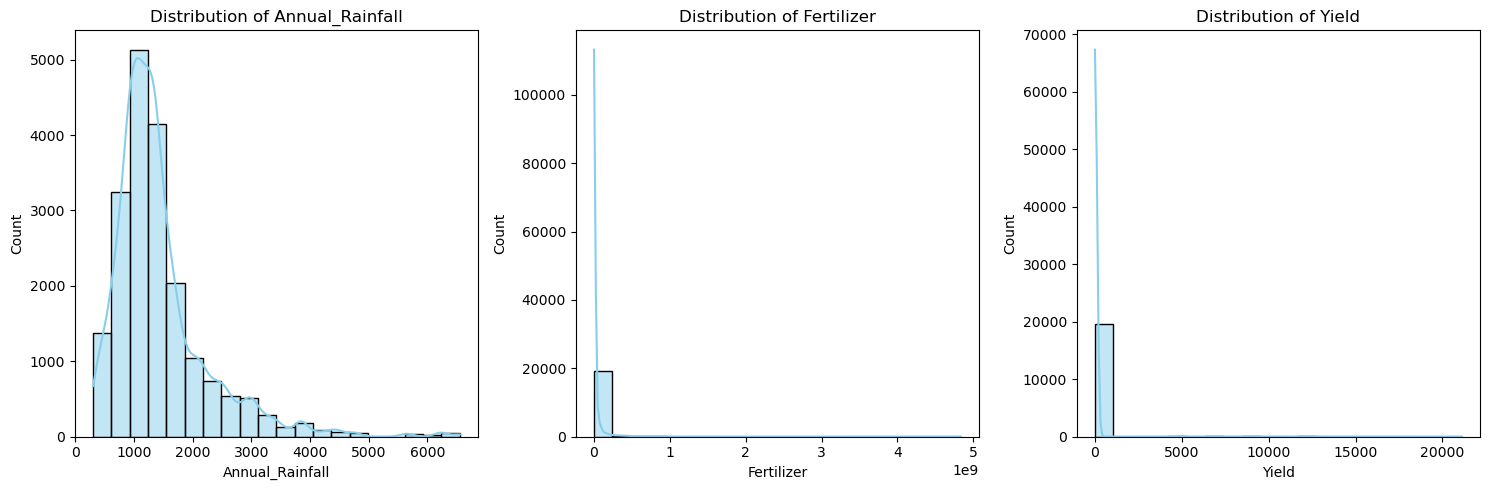

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution plots
plt.figure(figsize=(15,5))
for i, col in enumerate(["Annual_Rainfall", "Fertilizer", "Yield"], 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True, bins=20, color="skyblue")
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


C:\Users\ashra\AppData\Local\Temp\ipykernel_21272\498173808.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Season", data=df, palette="viridis")


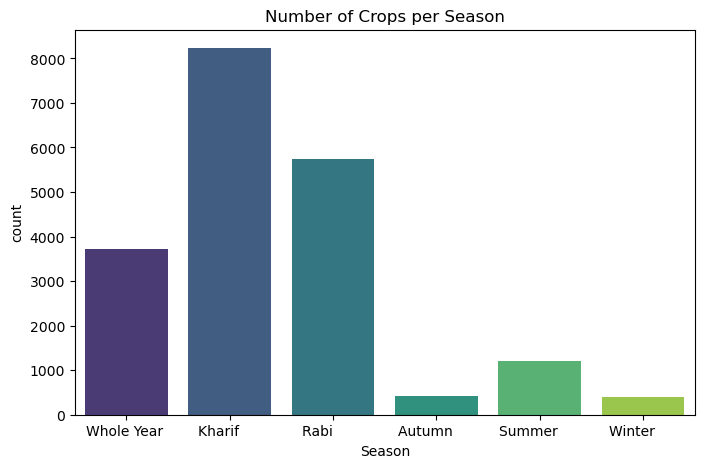

In [8]:
plt.figure(figsize=(8,5))
sns.countplot(x="Season", data=df, palette="viridis")
plt.title("Number of Crops per Season")
plt.show()


C:\Users\ashra\AppData\Local\Temp\ipykernel_21272\4282705427.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="State", y="Yield", data=df, palette="Set2")


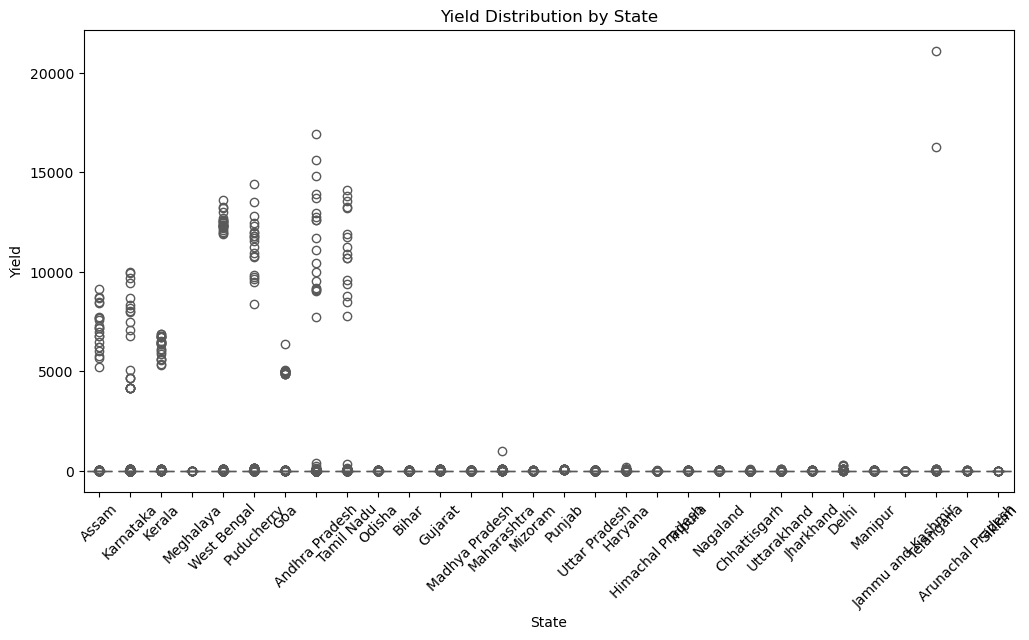

In [9]:
plt.figure(figsize=(12,6))
sns.boxplot(x="State", y="Yield", data=df, palette="Set2")
plt.title("Yield Distribution by State")
plt.xticks(rotation=45)
plt.show()

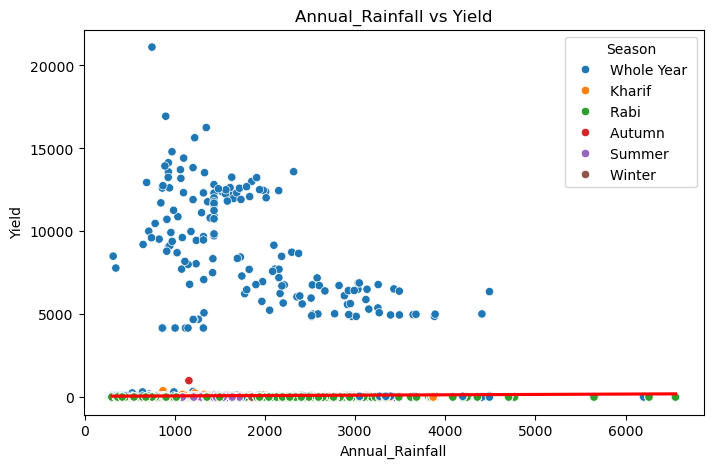

In [11]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="Annual_Rainfall", y="Yield", hue="Season", data=df, palette="tab10")
sns.regplot(x="Annual_Rainfall", y="Yield", data=df, scatter=False, color="red")
plt.title("Annual_Rainfall vs Yield")
plt.show()

C:\Users\ashra\AppData\Local\Temp\ipykernel_21272\2162093205.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Season", y="Yield", data=df, estimator="mean", palette="coolwarm")


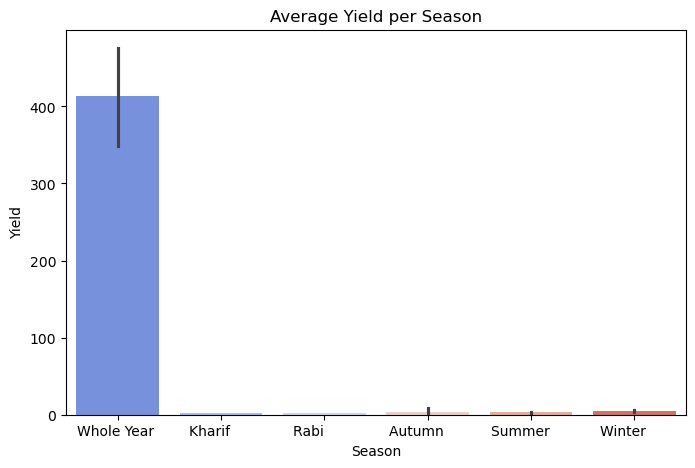

In [13]:
plt.figure(figsize=(8,5))
sns.barplot(x="Season", y="Yield", data=df, estimator="mean", palette="coolwarm")
plt.title("Average Yield per Season")
plt.show()


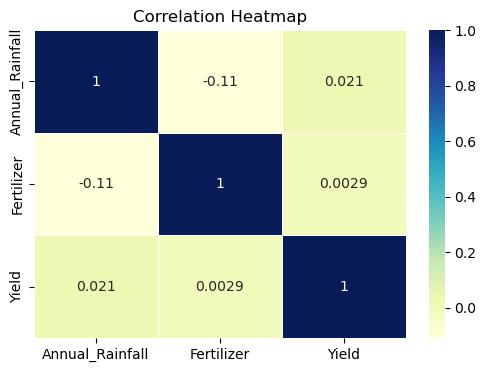

In [15]:
plt.figure(figsize=(6,4))
sns.heatmap(df[["Annual_Rainfall","Fertilizer","Yield"]].corr(), annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()